In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib as mpl
from cmcrameri import cm

from greedy_hospital_tmp import add_temp_facility, greedy_tmp, wait_disagg_tmp, manual_order_tmp
from greedy_hospital import import_data, greedy, manual_order, calculate_area, create_times, get_cons_order, get_capacity_order, wait_disagg
from cons_simulation import *

/opt/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Import Data

In [5]:
hosp_data = pd.read_csv('../Data/lima_test.csv')
H, H0, H_all, f, svr, mu, DIST, T = import_data(hosp_data)

# Variables
num_crews = 1
prio = [1,2] # number of priority levels
avg_speed = 30 # km/hr

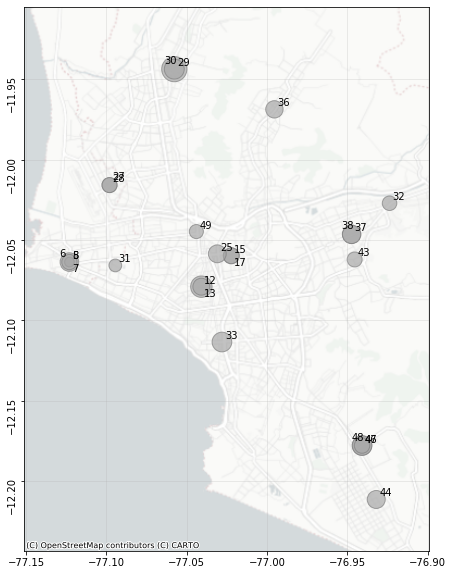

In [9]:
# buildings
bldg_id = hosp_data['ID'].values
lon = hosp_data['lon'].values
lat = hosp_data['lat'].values
size = [mu[h]*svr[h]*15 for h in bldg_id]

geo_dict = {'ID': bldg_id, 'size': size, 'geometry': [Point(xy) for xy in zip(lon,lat)]}
geo_df = gpd.GeoDataFrame(geo_dict, crs = 'epsg:4326')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # setup the plot
geo_df.plot(ax = ax, markersize = geo_df['size'], color = 'darkgrey', edgecolors = 'grey', alpha = 0.7)

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.ID):
    if label == 48 or label == 38 or label == 30 or label == 6:
        ax.annotate(label, xy=(x, y), xytext=(-10, 5), textcoords="offset points")
    elif label == 27:
        ax.annotate(label, xy=(x, y), xytext=(3, 5), textcoords="offset points")
    elif label == 13 or label == 7 or label == 17:
        ax.annotate(label, xy=(x, y), xytext=(3, -10), textcoords="offset points")
    else:
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels, zoom = 11)
ax.grid(alpha = 0.3)
plt.yticks(rotation = 90)
plt.show()

# Run Policies

In [10]:
# Greedy algorithm
greedy_order, results = greedy(H,H0, T, f, svr, mu, prio, avg_speed, dist_dict = DIST)

Intializing Arrays... Calculating Initial Allocation
Calculating Calculation Ordering...
chosen facility 28
chosen facility 30
chosen facility 49
chosen facility 36
chosen facility 33
chosen facility 31
chosen facility 32
chosen facility 7
chosen facility 6
Construction Order: [28, 30, 49, 36, 33, 31, 32, 7, 6]


In [11]:
calculate_area(greedy_order, results['cost_total'], T, unit = 'day')

96.28410023084223

In [12]:
# Fastest Construction Time
cons_order = get_cons_order(T, H)
print('Construction Order:', cons_order)
cons_results = manual_order(cons_order, H,H0, f, svr, mu, prio, avg_speed, dist_dict = DIST)
print('area:', calculate_area(cons_order, cons_results['cost_total'], T, unit = 'day'))

# Most Capacity
capacity_order = get_capacity_order(svr, H)
print('Capacity Order:', capacity_order)
capacity_results = manual_order(capacity_order, H,H0, f, svr, mu, prio, avg_speed, dist_dict = DIST)
print('area:', calculate_area(capacity_order, capacity_results['cost_total'], T, unit = 'day'))

Construction Order: [6, 28, 30, 31, 36, 49, 7, 33, 32]
area: 197.37853246547823
Capacity Order: [30, 33, 36, 28, 32, 49, 31, 6, 7]
area: 341.71488903804925


# Plot Results

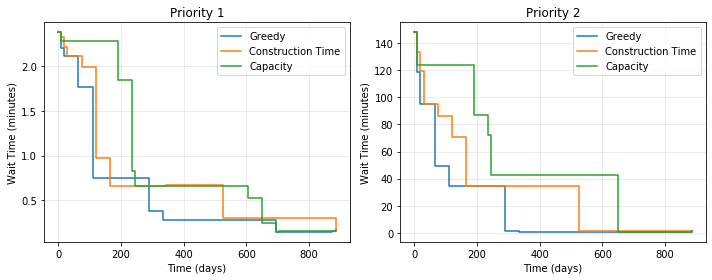

In [13]:
# Plot total time disagg by priority
orders_list = [greedy_order, cons_order, capacity_order]
results_list = [results, cons_results, capacity_results]
labels = ['Greedy', 'Construction Time', 'Capacity']

plt.figure(figsize = (10,4))

for k in prio:
    plt.subplot(1,2,k)
    
    for i in range(len(orders_list)):
        x_time = create_times(orders_list[i], T) 
        wait = wait_disagg('total', results_list[i], dist_dict = DIST, k = k)
        plt.plot(x_time, wait*60, drawstyle = 'steps-post', label = labels[i])
    
    plt.xlabel('Time (days)')
    plt.ylabel('Wait Time (minutes)')
    plt.grid('on', alpha = 0.3)
    plt.legend()
    plt.title('Priority {}'.format(k))

plt.tight_layout()
plt.show()